# Updated PCA

In [23]:
df = pd.read_csv('Data/default of credit card clients.csv')
df.rename(columns={'Default':'default'}, inplace=True)
df.index = df.ID
if 'ID' in df:
    del df['ID']
    
 
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

from sklearn.decomposition import PCA
pca=PCA(n_components=4)
X=df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
X_pca = pca.fit(X).transform(X)
print ('pca:', pca.components_)

pca: [[ 0.44758414  0.44176541  0.42968661  0.39797914  0.36991877  0.35306357]
 [ 0.55364282  0.39161138  0.07512402 -0.26727471 -0.45057905 -0.50992086]
 [-0.44992027 -0.03350715  0.71786681  0.29121344 -0.17374957 -0.40758078]
 [-0.19281276  0.16883483  0.41377134 -0.70645473 -0.1561488   0.4895412 ]]


In [24]:
from sklearn.preprocessing import StandardScaler
features = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
x = df.loc[:, features].values
y = df.loc[:,['default']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

C:\Users\otany\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,principal component 1,principal component 2
0,-1.611148,0.012479
1,-1.547595,-0.062344
2,-1.035874,0.011256
3,-0.250712,0.174374
4,-0.968951,-0.213032


In [25]:
pca.explained_variance_ratio_

array([ 0.90555253,  0.0509867 ])

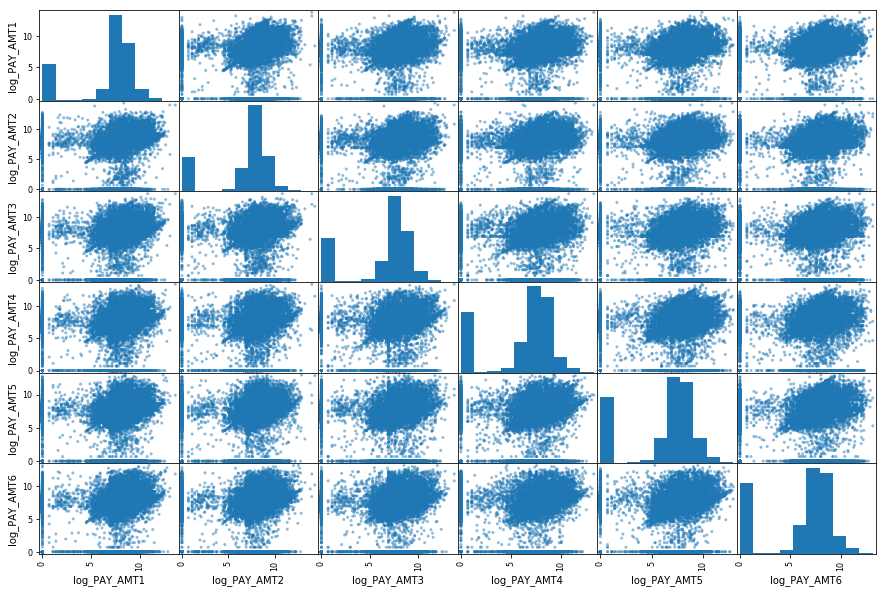

In [26]:
from pandas.plotting import scatter_matrix
%matplotlib inline
ax = scatter_matrix(df[["log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]],figsize=(15,10))


After log transformation of PAY_AMTs, we do not need to include them to PCA, since no strong correlation were seen on plots above.

# Training and Testing Split

For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into scikit-learn.

In [27]:
# perform one-hot encoding of the categorical data "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
df_imputed = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)
df_imputed.head

<bound method NDFrame.head of        LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                            
1          20000    2          2         1   24      2      2     -1     -1   
2         120000    2          2         2   26     -1      2      0      0   
3          90000    2          2         2   34      0      0      0      0   
4          50000    2          2         1   37      0      0      0      0   
5          50000    1          2         1   57     -1      0     -1      0   
6          50000    1          1         2   37      0      0      0      0   
7         500000    1          1         2   29      0      0      0      0   
8         100000    2          2         2   23      0     -1     -1      0   
9         140000    2          3         1   28      0      0      2      0   
10         20000    1          3         2   35     -2     -2     -2     -2   
11        200000    2 

In [29]:
Part_of_df_1 = df_imputed[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','EDUCATION_5','EDUCATION_6', 'MARRIAGE_0',
                         'MARRIAGE_1','MARRIAGE_2','MARRIAGE_3','AGE', 'default','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                           'PAY_6', "log_LIMIT_BAL","log_PAY_AMT1","log_PAY_AMT2",
                         "log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
#finalDf.loc[0] = 'NaN'
principalDf.index = np.arange(1, len(df) + 1)
final_Data_Frame_1 = pd.concat([principalDf, Part_of_df_1], axis=1)
final_Data_Frame_1.head

<bound method NDFrame.head of        principal component 1  principal component 2  SEX  EDUCATION_1  \
ID                                                                      
1                  -1.611148               0.012479    2            0   
2                  -1.547595              -0.062344    2            0   
3                  -1.035874               0.011256    2            0   
4                  -0.250712               0.174374    2            0   
5                  -0.968951              -0.213032    1            0   
6                  -0.240170               0.551237    1            1   
7                  15.317123              -2.898487    1            1   
8                  -1.579854               0.049338    2            0   
9                  -1.256409               0.010554    2            0   
10                 -1.473040              -0.252059    1            0   
11                 -1.451168               0.064053    2            0   
12                 -1

In [30]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'default' in final_Data_Frame_1:
    y = final_Data_Frame_1['default'].values # get the labels we want
    del final_Data_Frame_1['default'] # get rid of the class label
    X = final_Data_Frame_1.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)


ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


# Logistic Regression 1

In [31]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None) # get object
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
      

====Iteration 0  ====
accuracy 0.807166666667
confusion matrix
 [[4505  160]
 [ 997  338]]
====Iteration 1  ====
accuracy 0.806666666667
confusion matrix
 [[4525  180]
 [ 980  315]]
====Iteration 2  ====
accuracy 0.805666666667
confusion matrix
 [[4491  180]
 [ 986  343]]
====Iteration 3  ====
accuracy 0.816833333333
confusion matrix
 [[4539  149]
 [ 950  362]]
====Iteration 4  ====
accuracy 0.816333333333
confusion matrix
 [[4574  186]
 [ 916  324]]


# Interpretting weights 1


In [32]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = final_Data_Frame_1.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct?

principal component 1 has weight of 0.0388040456847
principal component 2 has weight of -0.0625200808349
SEX has weight of -0.0891507342474
EDUCATION_1 has weight of 0.555999643541
EDUCATION_2 has weight of 0.539984719532
EDUCATION_3 has weight of 0.519481220074
EDUCATION_4 has weight of -0.285473147575
EDUCATION_5 has weight of -0.701558762568
EDUCATION_6 has weight of 0.342445609723
MARRIAGE_0 has weight of -0.605681130474
MARRIAGE_1 has weight of 0.547062022852
MARRIAGE_2 has weight of 0.377284348842
MARRIAGE_3 has weight of 0.435269159478
AGE has weight of 0.00408191556822
PAY_0 has weight of 0.456422846087
PAY_2 has weight of 0.0679557179601
PAY_3 has weight of 0.0687769782829
PAY_4 has weight of 0.0279201890804
PAY_5 has weight of 0.0991342806348
PAY_6 has weight of 0.0952315345267
log_LIMIT_BAL has weight of -0.148799572719
log_PAY_AMT1 has weight of -0.0527352308072
log_PAY_AMT2 has weight of -0.0502496216299
log_PAY_AMT3 has weight of -0.0495852237257
log_PAY_AMT4 has weight o

These weight interpretations are not neccessarily interpretable because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their poredictive power in the logistic regression model.

In [35]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,final_Data_Frame_1.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.798666666667
[[4469  153]
 [1055  323]]
log_PAY_AMT1 has weight of -0.193338400876
log_PAY_AMT3 has weight of -0.174653735648
log_LIMIT_BAL has weight of -0.130745853295
log_PAY_AMT2 has weight of -0.127132279223
log_PAY_AMT4 has weight of -0.118010856848
EDUCATION_5 has weight of -0.0962184783391
MARRIAGE_0 has weight of -0.0564298830834
EDUCATION_4 has weight of -0.0541073333201
log_PAY_AMT5 has weight of -0.0510425246867
log_PAY_AMT6 has weight of -0.0448676389345
MARRIAGE_2 has weight of -0.042128859607
principal component 2 has weight of -0.032289956876
SEX has weight of -0.0286880360633
EDUCATION_6 has weight of -0.0095531370075
PAY_4 has weight of 0.00857605951125
MARRIAGE_3 has weight of 0.0106228243997
EDUCATION_3 has weight of 0.0318374837945
AGE has weight of 0.042642416412
MARRIAGE_1 has weight of 0.0447963616496
EDUCATION_2 has weight of 0.0507362712701
EDUCATION_1 has weight of 0.0556050660065
PAY_2 has weight of 0.0687278713352
principal component 1 has weigh

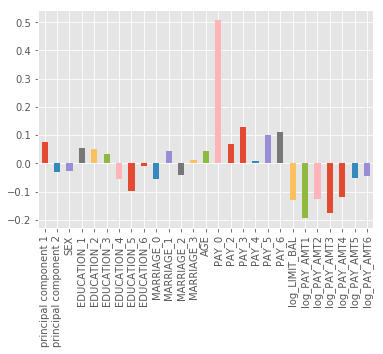

In [36]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=final_Data_Frame_1.columns)
weights.plot(kind='bar')
plt.show()

# Support Vector Machines

In [37]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [38]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.812166666667
[[4437  213]
 [ 914  436]]


In [39]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(10381, 27)
(10381,)
[5674 4707]


In [41]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = final_Data_Frame_1.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['default'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
final_Data_Frame_1['default'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10381 entries, 11426 to 21937
Data columns (total 28 columns):
principal component 1    10381 non-null float64
principal component 2    10381 non-null float64
SEX                      10381 non-null int64
EDUCATION_1              10381 non-null uint8
EDUCATION_2              10381 non-null uint8
EDUCATION_3              10381 non-null uint8
EDUCATION_4              10381 non-null uint8
EDUCATION_5              10381 non-null uint8
EDUCATION_6              10381 non-null uint8
MARRIAGE_0               10381 non-null uint8
MARRIAGE_1               10381 non-null uint8
MARRIAGE_2               10381 non-null uint8
MARRIAGE_3               10381 non-null uint8
AGE                      10381 non-null int64
PAY_0                    10381 non-null int64
PAY_2                    10381 non-null int64
PAY_3                    10381 non-null int64
PAY_4                    10381 non-null int64
PAY_5                    10381 non-null int64
PAY_6    

C:\Users\otany\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


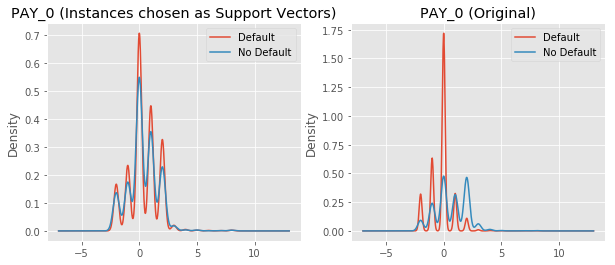

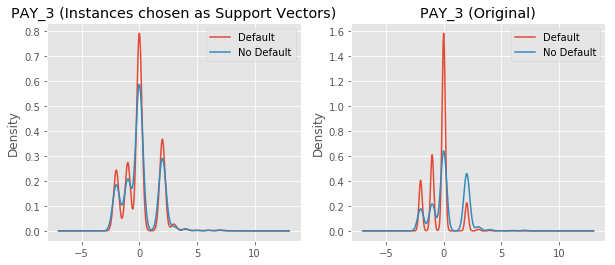

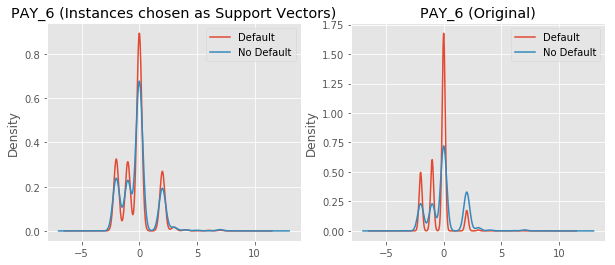

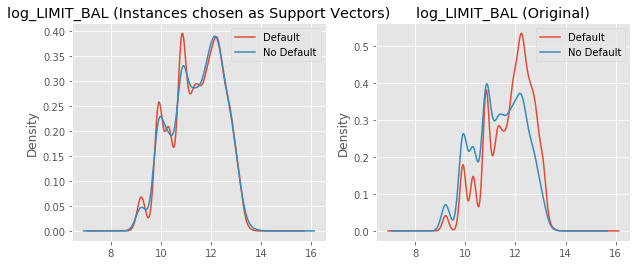

In [45]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['default'])
df_grouped = df_imputed.groupby(['default'])

# plot KDE of Different variables
vars_to_plot = ['PAY_0','PAY_3','PAY_6','log_LIMIT_BAL']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Default','No Default'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Default','No Default'])
    plt.title(v+' (Original)')



So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.